100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 16.50it/s]


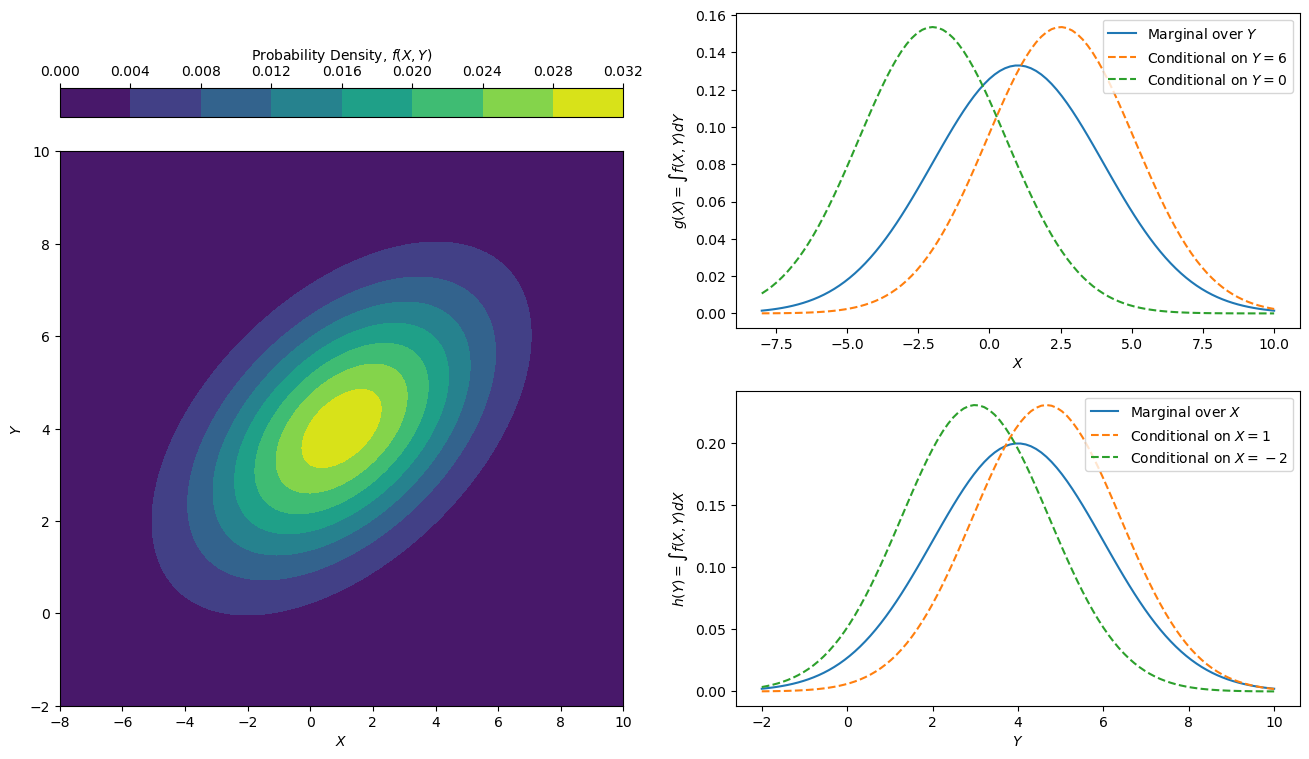

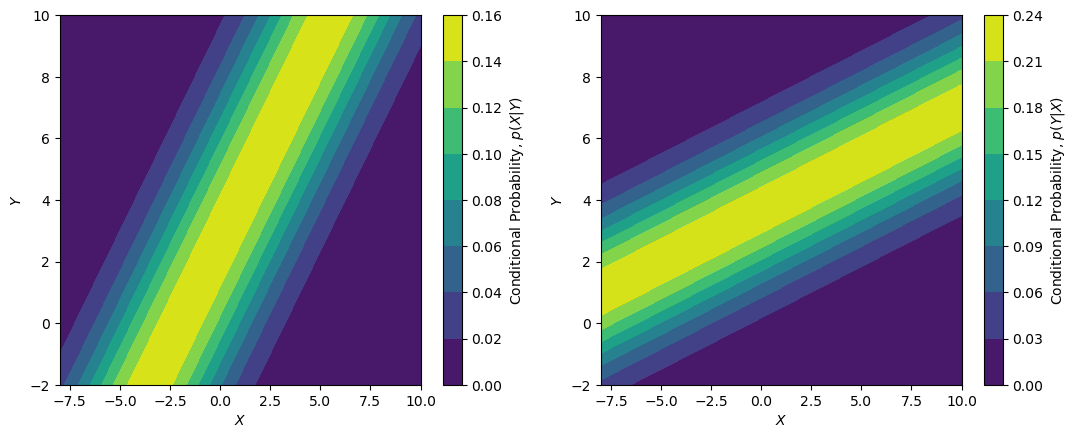

In [1]:
# let's not waste any time and use scip multivar_normal
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt


def get_mvn( mean, cov, marginal=None, conditional=None, verbose=False):
    """ get mvn distribution or any marginal or conditional subset of it
    
    Parameters
    ----------
    mean : array
        mu values of the multivariate normal. must be 1 dimensional.
    cov : array 
        covariance matrix of the multivariate normal. must be 2 dimensional
    marginal : int or array of int
        index or list of indices for which to marginalise over
    conditional : tuple or array of tuple
        must be a two element tuple or list of two element tuples which give (ind: val),
        the index and value which to be conditional upon
    """
    mean = np.asarray(mean)
    cov  = np.asarray(cov)
    # checks
    assert( mean.ndim==1 )
    assert( cov.ndim==2 )
    assert( mean.shape[0] == cov.shape[0] )
    assert( cov.shape[0] == cov.shape[1] )

    ndim = mean.shape[0]

    if marginal is not None:
        if np.isscalar( marginal ):
            marginal = [ marginal ]
        marginal = np.asarray( marginal )
        assert( len(marginal) < ndim )

        mmean = np.delete( mean, marginal, axis=0 )
        mcov  = np.delete( np.delete( cov, marginal, axis=0 ), marginal, axis=1 )
        
        return mvn( mmean, mcov )

    elif conditional is not None:
        conditional = np.asarray( conditional )

        argdrop = conditional[:,0].astype(np.int32)
        argkeep = np.array( [ i for i in range(ndim) if i not in argdrop ] )
        condvals = conditional[:,1]
        
        m1 = mean[argkeep] 
        m2 = mean[argdrop]

        S11 = cov[ np.ix_(argkeep, argkeep) ] 
        S22 = cov[ np.ix_(argdrop, argdrop) ]
        S12 = cov[ np.ix_(argkeep, argdrop) ] 
        S21 = cov[ np.ix_(argdrop, argkeep) ]
        
        cov_inv = np.linalg.inv( cov )
        cov1_inv = np.delete( np.delete( cov_inv, argdrop, axis=0), argdrop, axis=1 )
        cov1 = np.linalg.inv( cov1_inv )
        
        S22_inv = np.linalg.inv( S22 )

        cmean = m1 + S12 @ S22_inv @ ( condvals - m2 )
        ccov = S11 - S12 @ S22_inv @ S21
        
        return mvn( cmean, ccov )

    else:
        return mvn( mean, cov )

mu1 = 1
mu2 = 4
sg1 = 3
sg2 = 2

# 4d example
# mean = np.array([1, 4, 2, 3])
# err  = np.array([3, 2, 1, 4]).reshape((-1,1))
# corr = np.array([[1,0.5,0.2,0.2],[0.5,1,0.2,0.2],[0.2,0.2,1,0.6],[0.2,0.2,0.6,1]])
# cov  = err.T * corr * err
# get_mvn( mean, cov, conditional=[(2,3),(3,4)] )


# 2d example
mean = np.array( [mu1,mu2] )
err  = np.array( [sg1,sg2] ).reshape( (-1,1) )
corr = np.array( [[1,0.5],[0.5,1]] )
cov  = err.T * corr * err

dist_xy = get_mvn( mean, cov )
marg_x  = get_mvn( mean, cov, marginal=1 )
marg_y  = get_mvn( mean, cov, marginal=0 )

# Make some plots 
xrange = [ mu1 - 3*sg1, mu1 + 3*sg1 ]
yrange = [ mu2 - 3*sg2, mu2 + 3*sg2 ]
x = np.linspace(*xrange,100)
y = np.linspace(*yrange,100)
X, Y = np.meshgrid(x,y)

# The 2D distribution and the 1D marginals
from matplotlib.gridspec import GridSpec
fig = plt.figure( figsize=(16,9) )
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot( gs[:,0] )
ax2 = fig.add_subplot( gs[0,1] )
ax3 = fig.add_subplot( gs[1,1] )
pos = np.dstack([X,Y])
Z = dist_xy.pdf(pos)
im = ax1.contourf( X, Y, Z )
cb = fig.colorbar(im, ax=ax1, location='top')
cb.set_label('Probability Density, $f(X,Y)$')
ax1.set_xlabel('$X$')
ax1.set_ylabel('$Y$')

# The 1D marginal distributions
ax2.plot( x, marg_x.pdf( x.reshape((-1,1)) ), label='Marginal over $Y$' )
ax3.plot( y, marg_y.pdf( y.reshape((-1,1)) ), label='Marginal over $X$' )
# add some 1d conditional distributions
cond_x1 = get_mvn(mean, cov, conditional=[(1,6)])
cond_x2 = get_mvn(mean, cov, conditional=[(1,0)])
ax2.plot( x, cond_x1.pdf( x.reshape((-1,1)) ), ls='--', label='Conditional on $Y=6$')
ax2.plot( x, cond_x2.pdf( x.reshape((-1,1)) ), ls='--', label='Conditional on $Y=0$')
cond_y1 = get_mvn(mean, cov, conditional=[(0,3)])
cond_y2 = get_mvn(mean, cov, conditional=[(0,-2)])
ax3.plot( y, cond_y1.pdf( y.reshape((-1,1)) ), ls='--', label='Conditional on $X=1$')
ax3.plot( y, cond_y2.pdf( y.reshape((-1,1)) ), ls='--', label='Conditional on $X=-2$')
ax2.set_xlabel('$X$')
ax2.set_ylabel('$g(X) = \int f(X,Y) dY$')
ax2.legend()
ax3.set_xlabel('$Y$')
ax3.set_ylabel('$h(Y) = \int f(X,Y) dX$')
ax3.legend()
fig.savefig('multivar.pdf')

# Now we do the 2D conditional
Z_XY = Z / marg_y.pdf( Y.reshape( (*Y.shape,1) ) )
Z_YX = Z / marg_x.pdf( X.reshape( (*X.shape,1) ) )
fig, ax = plt.subplots(1, 2, figsize=(12.8,4.8))
im = ax[0].contourf( X, Y, Z_XY )
cb = fig.colorbar(im, ax=ax[0])
cb.set_label('Conditional Probability, $p(X|Y)$')
ax[0].set_xlabel('$X$')
ax[0].set_ylabel('$Y$')
im = ax[1].contourf( X, Y, Z_YX )
cb = fig.colorbar(im, ax=ax[1])
cb.set_label('Conditional Probability, $p(Y|X)$')
ax[1].set_xlabel('$X$')
ax[1].set_ylabel('$Y$')
fig.savefig('multivar_cond.pdf')

# try a 3D Gaussian example making a .gif
mu3 = 6 
sg3 = 2
z = np.linspace( mu3-3*sg3, mu3+3*sg3, 100)
mean = np.array( [ mu1, mu2, mu3 ] )
err  = np.array( [ sg1, sg2, sg3] ).reshape( (-1,1) ) 
corr = np.array( [ [1,0.5,-0.2],[0.5,1,0.1],[-0.2,0.1,1] ] )
cov  = err.T * corr * err

import os
from tqdm import tqdm

os.system('mkdir -p figs/forgif')
for i in tqdm(range(len(z))):
    pz = z[i]
    dist = get_mvn( mean, cov, conditional=[(2,pz)] )
    P = dist.pdf( pos )
    fig, ax = plt.subplots(2, 1, height_ratios=[1,15])
    ax[0].plot( pz, 0.0022, marker='$\downarrow$', ms=10, c='r', clip_on=False )
    ax[0].set_xlabel('$Z$')
    ax[0].set_xlim( z[0], z[-1] )
    ax[0].set_ylim( 0, 0.005)
    ax[0].tick_params(axis='x', which='both', top=False)
    ax[0].yaxis.set_visible(False)
    ax[0].spines[['top','right','left']].set_visible(False)
    im = ax[1].contourf( X, Y, P )
    cb = fig.colorbar( im, ax=ax[1] )
    cb.set_label('Probability Density')
    # ax[1].text(0.1,1.05, f'$Z={pz:4.2f}$', transform=ax[1].transAxes, clip_on=False)
    ax[1].set_xlabel('$X$')
    ax[1].set_ylabel('$Y$')
    fig.savefig(f'plot{i}.png')
    plt.close(fig)

# make a gif
from PIL import Image
frames = [ Image.open(f'plot{i}.png') for i in range(100) ]
frames[0].save( 'multivar.gif', format='GIF', append_images=frames[1:], save_all=True, duration=200, loop=0 )

plt.show()

